In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from tqdm.auto import tqdm
from mido import Message, MidiFile, MidiTrack
import torchmetrics
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or


In [2]:
!git clone https://github.com/czhuang/JSB-Chorales-dataset.git

fatal: destination path 'JSB-Chorales-dataset' already exists and is not an empty directory.


In [3]:
with open('JSB-Chorales-dataset/jsb-chorales-16th.pkl', 'rb') as p:
    data = pickle.load(p, encoding="latin1")

In [4]:
n_embd = 128
n_head = 8
head_size = n_embd // n_head
block_size=4
dropout=0.2

In [5]:
data.keys()

dict_keys(['test', 'train', 'valid'])

In [6]:
print(np.array(data['train'],dtype="object").shape)
print(np.array(data['test'],dtype="object").shape)
print(np.array(data['valid'],dtype="object").shape)

(229,)
(77,)
(76,)


In [7]:
train_data = data['train']
print(f"Type of train_data: {type(train_data)}")
print(f"Number of sequences in train_data: {len(train_data)}")
print(f"Type of the first sequence: {type(train_data[0])}")
print(f"Length of the first sequence: {len(train_data[0])}")
print(f"Type of the first element in the first sequence: {type(train_data[0][0])}")
print(f"Content of the first element in the first sequence:\n{train_data[0][0]}")

Type of train_data: <class 'list'>
Number of sequences in train_data: 229
Type of the first sequence: <class 'list'>
Length of the first sequence: 192
Type of the first element in the first sequence: <class 'tuple'>
Content of the first element in the first sequence:
(np.int64(74), np.int64(70), np.int64(65), np.int64(58))


In [8]:
train_dataset=data['train']
val_dataset=data['valid']
test_dataset=data['test']

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32)
test_loader=DataLoader(test_dataset,batch_size=32)

In [9]:
class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)

    # Learnable relative positional embeddings
    # The size should be enough to cover relative distances up to block_size
    # For relative bias, the maximum relative distance in a sequence of length T is T-1.
    # If we consider distances from -(T-1) to T-1, we need 2*T - 1 unique biases.
    # However, relative positional bias is typically based on the difference in indices (j-i).
    # For a sequence of length T, the relative positions j-i range from -(T-1) to T-1.
    # The number of unique relative positions is 2*T - 1.
    # A common approach for relative positional bias in self-attention is to have
    # biases for relative distances within a certain window size, often related to block_size.
    # Let's assume the relative bias is for distances up to block_size in both directions.
    # The relative distance between index i and j is j - i.
    # The range of j-i for i, j in [0, T-1] is -(T-1) to T-1.
    # We need biases for these relative distances.
    # A simpler form of relative bias is to have a bias tensor of shape (2*block_size - 1)
    # and map the relative distance (j-i) to an index in this tensor.

    # Let's redefine relative_bias to be for relative distances up to block_size
    # The relative distances (j-i) for 0 <= i, j < block_size range from -(block_size-1) to (block_size-1).
    # The number of unique relative distances is 2*block_size - 1.
    self.relative_bias = nn.Parameter(torch.randn(2 * block_size - 1))


  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)   # (B, T, head_size)
    q = self.query(x) # (B, T, head_size)
    v = self.value(x) # (B, T, head_size)

    # Compute attention scores ("affinities")
    # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
    wei = q @ k.transpose(-2, -1) * C**-0.5

    # Add relative positional bias
    # Calculate relative positions for the current sequence length T
    i = torch.arange(T).unsqueeze(1).to(x.device)
    j = torch.arange(T).unsqueeze(0).to(x.device)
    relative_positions = j - i # Shape (T, T)

    # Map relative positions to indices in self.relative_bias
    # The relative positions range from -(T-1) to T-1.
    # We need to map these to indices from 0 to 2*block_size - 2.
    # We can clip the relative positions to the range [-(block_size-1), block_size-1]
    # and then shift them to be non-negative indices.
    relative_positions_clipped = torch.clamp(relative_positions, min=-(block_size - 1), max=(block_size - 1))
    relative_bias_indices = relative_positions_clipped + (block_size - 1) # Shift to be non-negative

    # Lookup bias values using the indices
    # self.relative_bias has shape (2*block_size - 1)
    # relative_bias_indices has shape (T, T)
    # The lookup should result in a tensor of shape (T, T)
    relative_bias_to_add = self.relative_bias[relative_bias_indices] # Shape (T, T)

    # Add the relative bias to the attention scores
    wei = wei + relative_bias_to_add.unsqueeze(0) # Unsqueeze to broadcast across batch dimension (B, T, T) + (1, T, T)


    # Apply causal masking
    # The tril buffer was defined with block_size, need to adjust for current T
    tril_T = torch.tril(torch.ones(T, T, dtype=torch.bool, device=x.device))
    wei = wei.masked_fill(tril_T == 0, float('-inf')) # (B, T, T)


    # Apply softmax and dropout
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    wei = self.dropout(wei)

    # Perform the weighted aggregation of the values
    out = wei @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
    return out

In [10]:
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads=n_head, head_size=n_embd//n_head):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout) # Add dropout layer

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out)
    out = self.dropout(out)
    return out

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(n_head, head_size)
        self.norm1 = nn.LayerNorm(n_embd)
        self.norm2 = nn.LayerNorm(n_embd)

        self.ffwd = nn.Sequential(
            nn.Linear(n_embd, n_embd * 4),  # expand (feed-forward inner layer)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_embd * 4, n_embd),  # project back
            nn.Dropout(dropout),
        )

    def forward(self, input_tensor): # Renamed input variable
        # Pre-LN Attention
        # print(f"Shape before norm1 in TransformerBlock: {input_tensor.shape}") # Use input_tensor
        x = input_tensor + self.attn(self.norm1(input_tensor)) # Use input_tensor for norm1
        # print(f"Shape after attention in TransformerBlock: {x.shape}") # Add print statement

        # Pre-LN Feed Forward
        # print(f"Shape before norm2 in TransformerBlock: {x.shape}") # x is the output of attention
        x = x + self.ffwd(self.norm2(x))
        # print(f"Shape after ffwd in TransformerBlock: {x.shape}") # Add print statement

        return x

In [12]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    vocab_size=82 # Assuming this is the total number of unique note/event values across all voices
    self.embedding = nn.Embedding(vocab_size, n_embd)# Embedding layer to convert input tokens/events to embeddings
    self.transformer_blocks = nn.ModuleList([TransformerBlock(n_embd, n_head) for _ in range(8)])

    # Output linear layer to predict the probability distribution over the event vocabulary
    self.linear = nn.Linear(n_embd, vocab_size)

  def forward(self, x):
    # x shape: (batch_size, sequence_length, 4)
    batch_size, seq_len, num_voices = x.shape

    # Embed each of the 4 voice dimensions and sum the embeddings
    # This assumes the embeddings for each voice at a time step are additive.
    embeddings_sum = torch.zeros(batch_size, seq_len, n_embd, device=x.device)
    for i in range(num_voices):
        embeddings_sum += self.embedding(x[:, :, i])

    x_processed = embeddings_sum

    # Iterate through transformer blocks
    for i, block in enumerate(self.transformer_blocks):
        # The input to the transformer blocks is now (batch_size, sequence_length, n_embd)
        x_processed = block(x_processed)

    # The output of the last transformer block is (batch_size, sequence_length, n_embd)
    # Apply the linear layer to the last dimension (n_embd)
    # This will give output of shape (batch_size, seq_len, vocab_size)
    logits = self.linear(x_processed)

    return logits

In [13]:
model=Model()

In [14]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Using Adam optimizer with a learning rate of 0.001

# Define the loss function
criterion = nn.CrossEntropyLoss() # Using Cross-Entropy Loss, suitable for classification tasks like this

In [15]:
def pad_collate(batch):
    # Find the maximum sequence length in the batch
    max_len = max(len(seq) for seq in batch)
    if max_len == 0:
        return torch.empty(0, 0, 4, dtype=torch.long)

    batch_size = len(batch)
    # Create a tensor filled with padding values
    # Assuming padding value is 0
    padded_batch_tensor = torch.full((batch_size, max_len, 4), 0, dtype=torch.long)

    # Fill the tensor with actual sequence data
    for i, seq in enumerate(batch):
        # Debug prints for each sequence and its items
        # print(f"Processing Sequence {i}, Length: {len(seq)}")
        seq_list_of_lists = []
        for item_idx, item in enumerate(seq):
            # print(f"  Sequence {i}, Item {item_idx}: {item}, Type: {type(item)}")
            try:
                item_list = list(item)
                # print(f"  Sequence {i}, Item {item_idx}: Converted list: {item_list}, Length: {len(item_list)}")
                seq_list_of_lists.append(item_list)
            except Exception as e:
                print(f"  Sequence {i}, Item {item_idx}: Error converting item {item}: {e}")


        # Convert the sequence list of lists to a tensor
        if len(seq_list_of_lists) > 0:
            try:
                seq_tensor = torch.tensor(seq_list_of_lists, dtype=torch.long)
                 # print(f"  Sequence {i}: Created seq_tensor with shape {seq_tensor.shape}")
                # Place the sequence tensor into the pre-allocated batch tensor
                padded_batch_tensor[i, :len(seq), :] = seq_tensor
            except ValueError as e:
                 print(f"  Sequence {i}: ValueError when creating seq_tensor: {e}")
                 # You might want to inspect seq_list_of_lists here if this error occurs
                 # print(f"  Sequence {i}: seq_list_of_lists causing error: {seq_list_of_lists}")


    return padded_batch_tensor

# Re-initialize DataLoaders with the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=pad_collate)

print("DataLoaders re-initialized with custom collate function to handle variable sequence lengths.")

DataLoaders re-initialized with custom collate function to handle variable sequence lengths.


In [16]:
def train(model, train_loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_batches = 0 # Keep track of the number of batches

    # Wrap the train_loader with tqdm for a progress bar
    for i, inputs in enumerate(tqdm(train_loader, desc="Training")):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        # inputs shape: (batch_size, seq_len, 4)
        outputs = model(inputs) # outputs shape: (batch_size, seq_len, vocab_size)

        # Prepare targets
        # Assuming target for time step t is the first value at time step t+1
        # We need to shift the inputs to get the targets
        # targets shape: (batch_size, seq_len) - we will exclude the last time step
        targets = inputs[:, 1:, 0] # Take all batches, from second time step onwards, first feature
        # outputs shape for loss: (batch_size * (seq_len - 1), vocab_size)
        # targets shape for loss: (batch_size * (seq_len - 1))

        # Reshape outputs and targets for CrossEntropyLoss
        # CrossEntropyLoss expects inputs of shape (N, C) and targets of shape (N)
        batch_size, seq_len, vocab_size = outputs.shape
        # Exclude the last time step from outputs
        outputs_for_loss = outputs[:, :-1, :].contiguous().view(-1, vocab_size)
        # Flatten targets
        targets_for_loss = targets.contiguous().view(-1)


        loss = criterion(outputs_for_loss, targets_for_loss)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        total_batches += 1 # Increment batch count
        # We can update the progress bar description with the current loss
        if i % 10 == 9:
             tqdm.write(f'[{i + 1}] loss: {running_loss / (i + 1):.3f}') # Print average loss so far


    epoch_loss = running_loss / total_batches # Calculate average loss for the epoch
    print(f'Finished Training. Epoch Loss: {epoch_loss:.3f}')
    return epoch_loss # Return the average epoch loss

In [17]:
def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Initialize accuracy metric
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=82) # Assuming vocab_size is 82

    with torch.no_grad(): # Disable gradient calculation
        # Wrap the data_loader with tqdm for a progress bar
        for inputs in tqdm(data_loader, desc="Evaluating"):
            # Forward pass
            outputs = model(inputs)

            # Prepare targets
            targets = inputs[:, 1:, 0] # Take all batches, from second time step onwards, first feature

            # Reshape outputs and targets for CrossEntropyLoss
            batch_size, seq_len, vocab_size = outputs.shape
            outputs_for_loss = outputs[:, :-1, :].contiguous().view(-1, vocab_size)
            targets_for_loss = targets.contiguous().view(-1)

            # Calculate loss
            loss = criterion(outputs_for_loss, targets_for_loss)
            total_loss += loss.item() * inputs.size(0) # Accumulate loss, weighted by batch size

            # Calculate accuracy
            # Get the predicted token for each position
            predicted_tokens = torch.argmax(outputs_for_loss, dim=-1)
            # Update accuracy metric
            accuracy_metric.update(predicted_tokens.cpu(), targets_for_loss.cpu())


    average_loss = total_loss / len(data_loader.dataset) # Calculate average loss
    perplexity = torch.exp(torch.tensor(average_loss)) # Calculate perplexity
    accuracy = accuracy_metric.compute() # Compute final accuracy

    print(f'Evaluation Loss: {average_loss:.3f}, Perplexity: {perplexity:.3f}, Accuracy: {accuracy:.3f}')
    return average_loss, perplexity, accuracy # Return all metrics

# Evaluate on the validation set
# print("Evaluating on validation set...")
# evaluate(model, val_loader, criterion)

# Evaluate on the test set (optional, usually done after final model selection)
# print("Evaluating on test set...")
# evaluate(model, test_loader, criterion)

Starting training for 10 epochs...

Epoch 1/10


Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 21: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 27: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 9: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 16: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 0: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: 

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 30: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 1: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 4: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 4: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 11: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 2: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 19: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 4: V

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 1: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 2: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 15: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 23: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 26: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 16: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 24: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 19:

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 2: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 5: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 11: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 10: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 11: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 1: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 19: V

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 0: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 10: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 31: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 9: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 9: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 24: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 31: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 1: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: 

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 10: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 12: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 15: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 16: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 12: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 13: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 10: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 11: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 5: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 30: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 21: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 25: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 15: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 19: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 5: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 24

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 11: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 27: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 16: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 12: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 10: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 23: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 19: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 5: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 13: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 0: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 12: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 20: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 1: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 23: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 11: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 15: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 30:

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

Training:   0%|          | 0/8 [00:00<?, ?it/s]

  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 30: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 31: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 1: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 31: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 26: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 27: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 29: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 0: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 23: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 3

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 22: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 28: ValueError when creating seq_tensor: expected sequence of length 3 at dim 1 (got 4)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 8: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 14: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 17: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 1 at dim 1 (got 4)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
Evaluation Loss

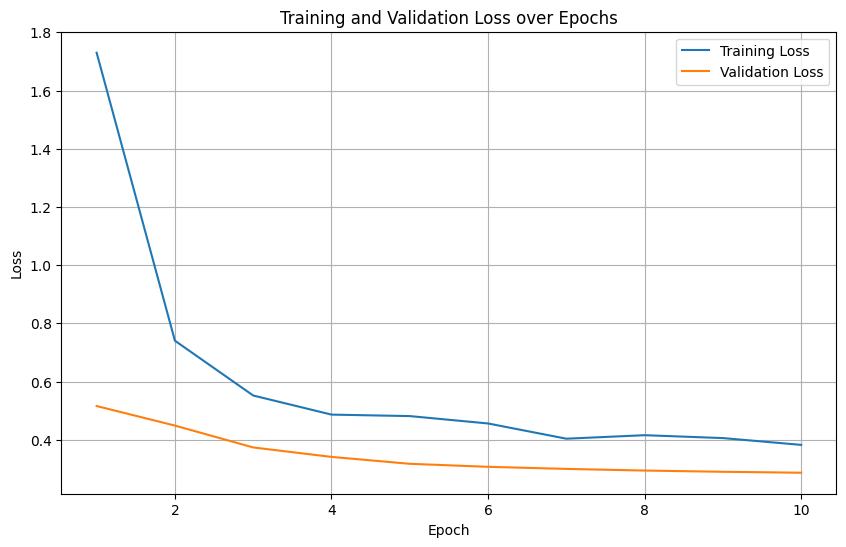

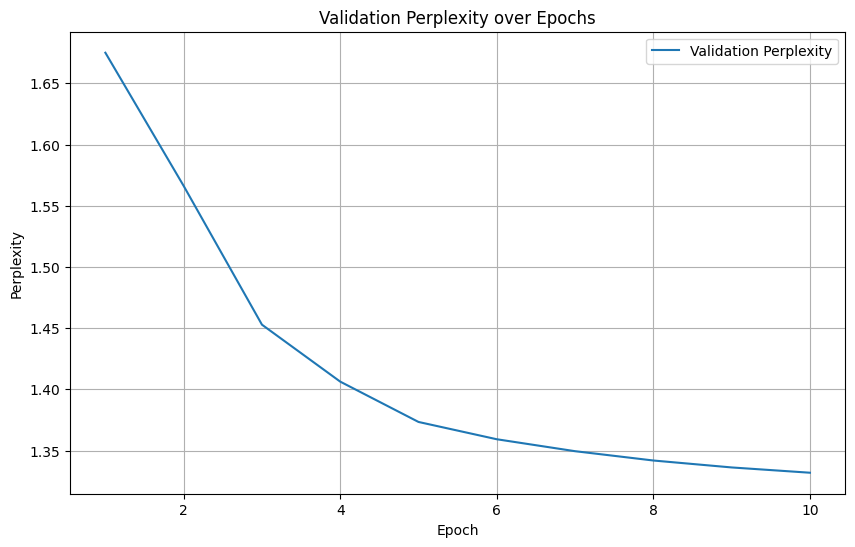

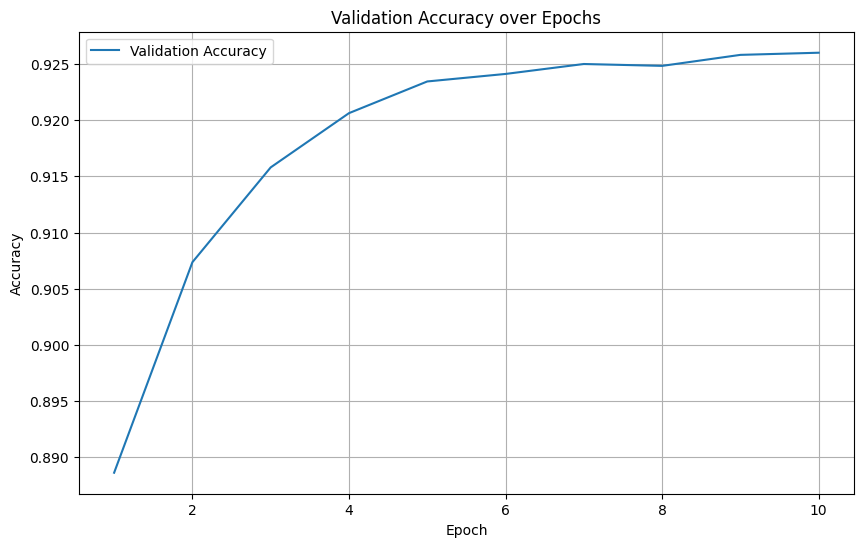

In [18]:
# Lists to store losses
train_losses = []
val_losses = []
val_perplexities = []
val_accuracies = []

num_epochs = 10 # Define the number of epochs

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    epoch_train_loss = train(model, train_loader, optimizer, criterion)
    train_losses.append(epoch_train_loss)

    # Evaluate on the validation set
    print(f"Evaluating after Epoch {epoch+1}...")
    epoch_val_loss, epoch_val_perplexity, epoch_val_accuracy = evaluate(model, val_loader, criterion)
    val_losses.append(epoch_val_loss)
    val_perplexities.append(epoch_val_perplexity.item()) # .item() to get scalar value
    val_accuracies.append(epoch_val_accuracy.item()) # .item() to get scalar value

    # Optional: Print validation metrics
    print(f"Epoch {epoch+1} - Val Loss: {epoch_val_loss:.3f}, Val Perplexity: {epoch_val_perplexity:.3f}, Val Accuracy: {epoch_val_accuracy:.3f}")


print("\nTraining finished.")

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plotting perplexity and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Define the path to save the model
model_save_path = 'final_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to final_model.pth


In [20]:
# Evaluate on the test set
print("Evaluating on test set...")
test_loss = evaluate(model, test_loader, criterion)

Evaluating on test set...


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 18: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 20: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 23: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 0: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 3: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 16: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 21: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 6: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 3)
  Sequence 7: ValueError when creating seq_tensor: expected sequence of length 4 at dim 1 (got 0)
  Sequence 12: 

In [22]:
model.load_state_dict(torch.load("final_model.pth"))
model.eval()


Model(
  (embedding): Embedding(82, 128)
  (transformer_blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attn): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (key): Linear(in_features=128, out_features=16, bias=False)
            (query): Linear(in_features=128, out_features=16, bias=False)
            (value): Linear(in_features=128, out_features=16, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffwd): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=512, out_features=128, bias=True)
        (4): Dropout